In [3]:
import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import RecalibratePredictions
from PREDICT.Metrics import *
from PREDICT.Triggers import SPCTrigger
from PREDICT.Plots import *

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

### COVID shock change

In [4]:
# Initialize dictionary
mydict = {
    'date': list(),
    'outcome': list(),
    'prediction': list(),
    'age': list(),
    'systolic_bp': list(),
    'flu_symptoms': list()
}

# Set random seed for reproducibility
np.random.seed(42)

# Define date range and COVID shock periods
startDate = pd.to_datetime('01-01-2020', dayfirst=True)
endDate = pd.to_datetime('31-12-2020', dayfirst=True)
switchDate = pd.to_datetime('01-03-2020', dayfirst=True)  # COVID starts spreading
switchDate2 = pd.to_datetime('01-06-2020', dayfirst=True)  # Peak of the pandemic
numdays = (endDate - startDate).days
switchDays = (switchDate - startDate).days
switch2Days = (switchDate2 - startDate).days

for i in range(numdays):
    curday = startDate + dt.timedelta(days=i)

    age = np.random.normal(70, 5, 5000) # Mean age 70 years, std 5
    systolic_bp = np.random.normal(120, 20, 5000) # Mean systolic blood pressure 120 mmHg, std 10
    # Calculate baseline log-odds
    lp = -1.5 + 0.5 * (age - 70) / 5 + 2 * (systolic_bp - 120) / 10
    curpredictions = 1 / (1 + np.exp(-lp))  # Convert to probability
    
    # Simulate COVID effects
    if i >= switchDays:
        lp += 1.5  # Increase incidence due to initial COVID impact
    if i >= switch2Days:
        lp += 2.0  # Further increase as the pandemic peaks
    
    # Simulate flu symptoms
    if i < switchDays:
        flu_symptoms = np.random.binomial(1, 0.1, 5000)  # Low baseline prevalence
    elif i < switch2Days:
        flu_symptoms = np.random.binomial(1, 0.3, 5000)  # Increased prevalence during COVID spread
    else:
        flu_symptoms = np.random.binomial(1, 0.5, 5000)  # Higher prevalence during pandemic peak
    
    # Generate outcomes
    curoutcomes = np.random.binomial(1, 1 / (1 + np.exp(-lp)))  # Simulate "heart attack" events
    
    # Append to dictionary
    mydict['date'].extend([curday] * 5000)
    mydict['outcome'].extend(curoutcomes)
    mydict['prediction'].extend(curpredictions)
    mydict['age'].extend(age)
    mydict['systolic_bp'].extend(systolic_bp) 
    mydict['flu_symptoms'].extend(flu_symptoms)

df = pd.DataFrame(mydict)

df.head()


,date,outcome,prediction,age,systolic_bp,flu_symptoms
0,2020-01-01,0,0.049894,72.483571,111.524806,0
1,2020-01-01,0,0.032838,69.308678,110.931718,0
2,2020-01-01,0,0.000234,73.238443,84.087137,0
3,2020-01-01,0,0.113162,77.615149,113.398196,0
4,2020-01-01,1,0.788222,68.829233,134.656582,0


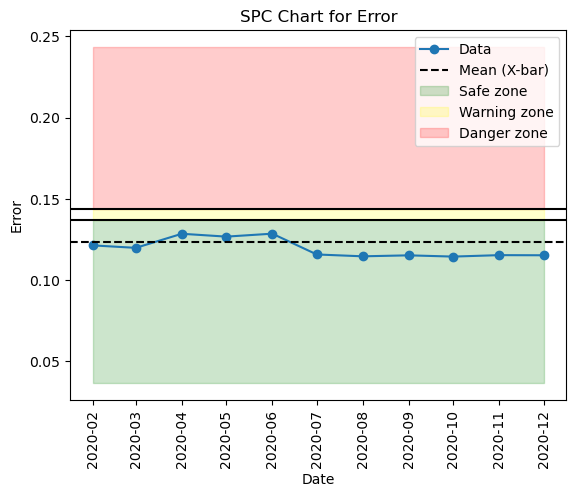

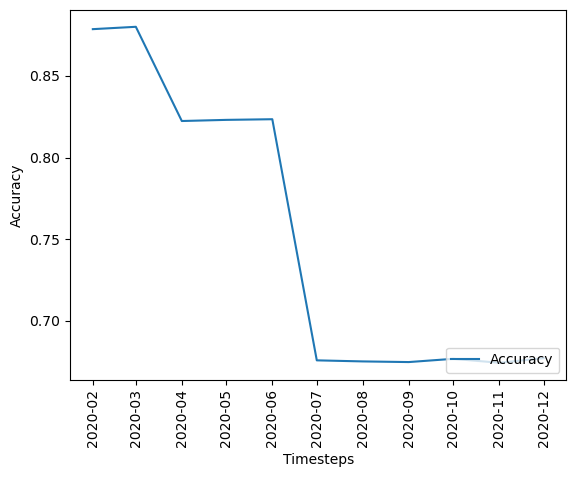

In [5]:
model = RecalibratePredictions()
model.trigger = SPCTrigger(model=model, input_data=df, numMonths=6)

mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='month')
mytest.addLogHook(Accuracy(model))
mytest.addLogHook(CalibrationSlope(model))
mytest.addLogHook(CITL(model))
mytest.addLogHook(LogRegError(model))
mytest.run()
log = mytest.getLog()
ErrorSPCPlot(log, model)
AccuracyPlot(log)
# CalibrationSlopePlot(log)
# LogRegErrorPlot(log)


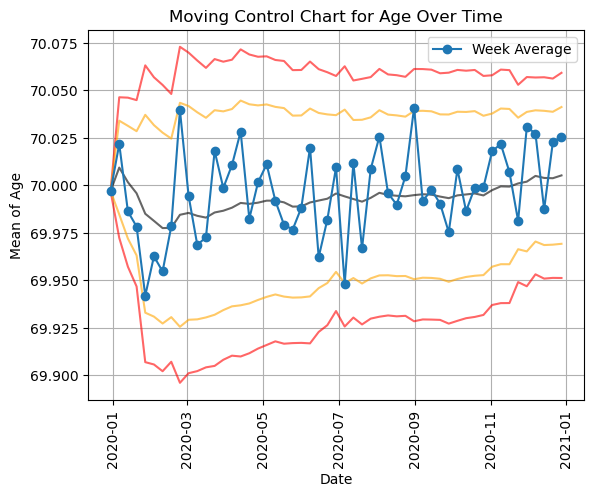

In [12]:
MonitorChangeSPC(input_data = df, trackCol='age', timeframe='Week', windowSize=20)

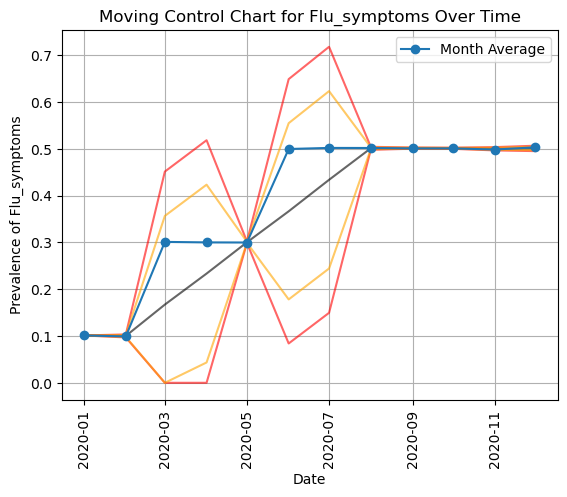

In [13]:
MonitorChangeSPC(input_data = df, trackCol='flu_symptoms', timeframe='Month', windowSize=3)